### Transfer learning in Ktrain
(image-classification) 

https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/examples/vision/planet-ResNet50.ipynb
https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-03-image-classification.ipynb

   The target dataset is small and different from the base training dataset.
Since the data is small, overfitting is a concern. Hence, we train only the linear layers. But as the target dataset is very different from the base dataset, the higher level features in the ConvNet would not be of any relevance to the target dataset. So, the new network will only use the lower level features of the base ConvNet. To implement this scheme, we:

  1. Remove most of the pre-trained layers near the beginning of the ConvNet
  2. Add to the remaining pre-trained layers new fully connected layers that match the number of classes in the new dataset
  3. Randomize the weights of the new fully connected layers and freeze all the weights from the pre-trained network
  4. Train the network to update the weights of the new fully connected layers


### Breast Cancer Detection
Score


https://dphi.tech/challenges/data-sprint-31-breast-cancer-detection/75/overview/about

In [1]:
# Подключим Google-disk и загрузим с него данные
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q /content/drive/MyDrive/Datasets/mammography_images.zip

In [3]:
!mkdir test
!mv mammography_images/test/ test

In [ ]:
#!cp  /content/gdrive/My\ Drive/model_weights.h5 ./

In [9]:
!ls mammography_images

sample_submission.csv  Testing_set.csv	train  Training_set.csv


In [5]:
!pip install -q ktrain  

     |████████████████████████████████| 25.3MB 129kB/s 
     |████████████████████████████████| 6.8MB 56.9MB/s 
     |████████████████████████████████| 983kB 52.4MB/s 
     |████████████████████████████████| 266kB 51.8MB/s 
     |████████████████████████████████| 1.9MB 49.4MB/s 
     |████████████████████████████████| 1.2MB 41.5MB/s 
     |████████████████████████████████| 471kB 49.4MB/s 
     |████████████████████████████████| 3.3MB 52.6MB/s 
     |████████████████████████████████| 901kB 48.4MB/s 


In [ ]:
########################################

In [6]:
import tensorflow as tf 
#import tensorflow_addons as tfa
print(tf.__version__)

2.4.1


In [7]:
import ktrain
from ktrain import vision as vis

import numpy as np
import pandas as pd


In [10]:
DATADIR = './mammography_images/'
train_df = pd.read_csv(DATADIR+"Training_set.csv")
test_df = pd.read_csv(DATADIR+"Testing_set.csv")

In [11]:
#train_df['filename'] = train_df['image_id']+'.jpg'
#test_df['filename'] = test_df['image_id']+'.jpg'

In [12]:
train_df.to_csv("train.csv", index=False, header=True) 
test_df.to_csv("test.csv", index=False, header=True) 

In [13]:
!ls

drive  mammography_images  sample_data	test  test.csv	train.csv


#### Data Preprocessing

In [14]:
ORIGINAL_DATA = 'train.csv'
CONVERTED_DATA = 'train-CONVERTED.csv'
labels = vis.preprocess_csv(ORIGINAL_DATA, 
                           CONVERTED_DATA, 
                           x_col='filename', y_col='label')

In [15]:
train_data, val_data, preproc = vis.data.images_from_csv(
                          CONVERTED_DATA,
                         'filename',
                          directory=DATADIR+'train',
                          val_filepath = None,
                          label_columns = labels,
                          data_aug=vis.get_data_aug(horizontal_flip=True, vertical_flip=True),
                          random_state=None #42
                        )

['Density1Benign', 'Density1Malignant', 'Density2Benign', 'Density2Malignant', 'Density3Benign', 'Density3Malignant', 'Density4Benign', 'Density4Malignant']
      Density1Benign  Density1Malignant  ...  Density4Benign  Density4Malignant
2496               0                  0  ...               0                  0
3764               0                  0  ...               0                  0
2425               0                  0  ...               0                  0
1989               0                  0  ...               0                  0
2060               1                  0  ...               0                  0

[5 rows x 8 columns]
['Density1Benign', 'Density1Malignant', 'Density2Benign', 'Density2Malignant', 'Density3Benign', 'Density3Malignant', 'Density4Benign', 'Density4Malignant']
      Density1Benign  Density1Malignant  ...  Density4Benign  Density4Malignant
653                0                  0  ...               1                  0
4864               0    

sample images:


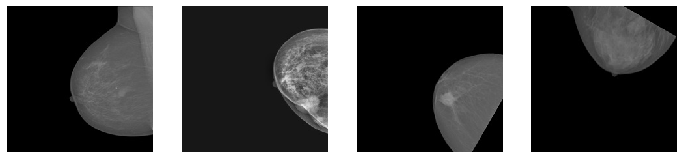

In [16]:
print('sample images:')
vis.show_random_images(DATADIR+'train')

In [17]:
# let's print the available precanned image classification models in ktrain
vis.print_image_classifiers()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized)
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized)
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized)
wrn22: 22-layer Wide Residual Network (randomly initialized)
default_cnn: a default LeNet-like Convolutional Neural Network


In [18]:
N_CLASSES = 8
model = vis.image_classifier('pretrained_resnet50', train_data, val_data=val_data, 
                             #metrics=[tfa.metrics.F1Score(num_classes=N_CLASSES , average="micro")],
                             #optimizer_name = 'adam',   #'sgd' ... 
                             freeze_layers=2, 
                             multilabel=False,   # !!! (True, False or None)
                             pt_fc = [],
                             pt_ps = [],
                             verbose=1)


The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? False
94773248/94765736 [==============================] - 1s 0us/step
pretrained_resnet50 model created.


In [19]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, 
                             batch_size=64, workers=8, use_multiprocessing=False)


In [ ]:
#learner.lr_find(max_epochs=10)
#learner.lr_plot()

In [ ]:
# Restore the model's state
#model.load_weights('model_weights.h5')

In [20]:
# Можно повторять этот шаг многократно, меняя кол. эпох (продолжает обучение)
learner.fit_onecycle(1e-4, 25)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/25
81/81 [==============================] - 96s 710ms/step - loss: 3.8489 - accuracy: 0.2195 - val_loss: 2.8345 - val_accuracy: 0.3089
Epoch 2/25
81/81 [==============================] - 60s 684ms/step - loss: 2.9696 - accuracy: 0.2808 - val_loss: 2.2017 - val_accuracy: 0.4101
Epoch 3/25
81/81 [==============================] - 62s 681ms/step - loss: 2.5633 - accuracy: 0.3651 - val_loss: 2.0127 - val_accuracy: 0.4729
Epoch 4/25
81/81 [==============================] - 62s 677ms/step - loss: 1.9238 - accuracy: 0.4899 - val_loss: 2.1776 - val_accuracy: 0.5323
Epoch 5/25
81/81 [==============================] - 62s 673ms/step - loss: 1.3714 - accuracy: 0.6004 - val_loss: 1.9224 - val_accuracy: 0.6021
Epoch 6/25
81/81 [==============================] - 61s 660ms/step - loss: 1.0161 - accuracy: 0.6892 - val_loss: 2.0817 - val_accuracy: 0.5899
Epoch 7/25
81/81 [==============================] - 61s 664ms/step - loss: 0.7

In [ ]:
# Save weights to a HDF5 file
#model.save_weights('model_weights.h5', save_format='h5')

#!cp model_weights.h5 /content/gdrive/My\ Drive/

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

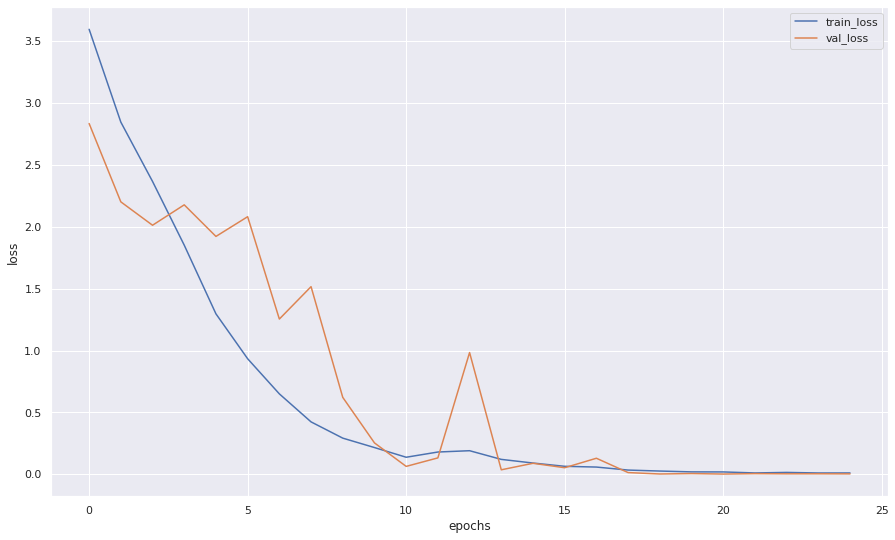

In [22]:
plt.figure(figsize=(15, 9))
plt.plot(learner.history.history['loss'], label="train_loss")
plt.plot(learner.history.history['val_loss'], label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

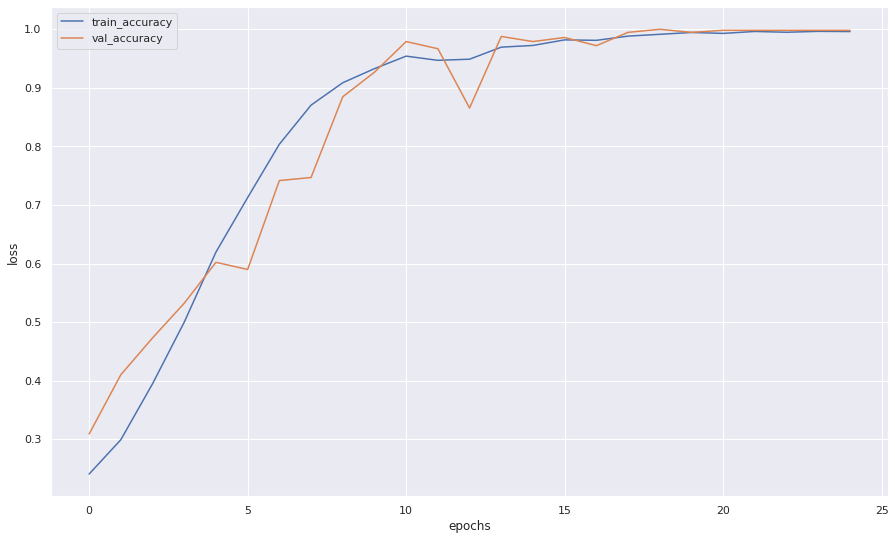

In [23]:
plt.figure(figsize=(15, 9))
plt.plot(learner.history.history['accuracy'], label="train_accuracy")
plt.plot(learner.history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Making Predictions
Let's make some predictions using our model and examine results. As before, we first create a Predictor instance.

In [24]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [25]:
TEST_IMAGES = './test/test'
predictions = predictor.predict_folder(TEST_IMAGES, return_proba=False)
predictions[0]

Found 1908 images belonging to 1 classes.


('test/Image_1.jpg', 'Density3Benign')

In [36]:
BEGIN = len('test/') 
pred = [ [int(filename[len('test/Image_'): -len('.jpg') ]),   filename[BEGIN: ], label] for filename, label in predictions]
pred[0]

[1, 'Image_1.jpg', 'Density3Benign']

In [39]:
result_file = 'KT_submission.csv'

result = pd.DataFrame(pred , columns=['id', 'filename', 'label']) 
result.sort_values(by=['id'], inplace=True)
result.drop(['id'], axis=1, inplace=True)

with open(result_file, 'w') as f:
    result.to_csv(f, index=False, header=True) 
    
result    


,filename,label
0,Image_1.jpg,Density3Benign
1020,Image_2.jpg,Density1Benign
1131,Image_3.jpg,Density2Malignant
1242,Image_4.jpg,Density1Benign
1353,Image_5.jpg,Density3Malignant
...,...,...
1006,Image_1904.jpg,Density1Malignant
1007,Image_1905.jpg,Density4Benign
1008,Image_1906.jpg,Density2Malignant
1009,Image_1907.jpg,Density2Malignant


In [ ]:
########################

In [40]:
from google.colab import files
files.download(result_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>